# Storage Benchmark

In this notebook, we'll compare the following storage formats:
- CSV: Comma-separated, standard flat text file format.
- HDF5: Hierarchical data format, developed initially at the National Center for Supercomputing Applications. It is a fast and scalable storage format for numerical data, available in pandas using the PyTables library.
- Parquet: Part of the Apache Hadoop ecosystem, a binary, columnar storage format that provides efficient data compression and encoding and has been developed by Cloudera and Twitter. It is available for pandas through the `pyarrow` library, led by Wes McKinney, the original author of pandas.

This notebook compares the performance of the preceding libraries using a test DataFrame that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table formats. The table format allows for queries and can be appended to.

## Usage

To recreate the charts used in the book, you need to run this notebook twice up to section 'Store Result' using different settings for `data_type` and arguments for `generate_test_data` as follows:
1. `data_type='Numeric`: `numerical_cols=2000`, `text_cols=0` (default)
2. `data_type='Mixed`: `numerical_cols=1000`, `text_cols=1000`

## Imports & Settings

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

In [6]:
sns.set_style('whitegrid')

In [7]:
results = {}

## Generate Test Data

The test `DataFrame` that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table format. 

In [8]:
def generate_test_data(nrows=100000, numerical_cols=1000, text_cols=1000, text_length=10):
    s = "".join([random.choice(string.ascii_letters)
                 for _ in range(text_length)])
    data = pd.concat([pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
                      pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s))],
                     axis=1, ignore_index=True)
    data.columns = [str(i) for i in data.columns]
    return data

In [9]:
#data_type = 'Numeric'

In [10]:
df = generate_test_data(numerical_cols=1000, text_cols=1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 2000 entries, 0 to 1999
dtypes: float64(1000), object(1000)
memory usage: 1.5+ GB


## Parquet

### Size

In [11]:
parquet_file = Path('test.parquet')

In [12]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

### Read

In [13]:
%%timeit -o
df = pd.read_parquet(parquet_file)

5.72 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 5.72 s ± 164 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [14]:
read = _

In [15]:
parquet_file.unlink()

### Write

In [16]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

26.6 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 26.6 s ± 1.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [17]:
write = _

### Results

In [18]:
results['Parquet'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## HDF5

In [19]:
test_store = Path('index.h5')

### Fixed Format

#### Size

In [20]:
with pd.HDFStore(test_store) as store:
    store.put('file', df)
size = test_store.stat().st_size

#### Read

In [21]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

2min 46s ± 2.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2min 46s ± 2.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [22]:
read = _

In [23]:
test_store.unlink()

#### Write

In [24]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

41.5 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 41.5 s ± 220 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
write = _

#### Results

In [26]:
results['HDF Fixed'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Format

#### Size

In [27]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
size = test_store.stat().st_size    

#### Read

In [28]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

1min 5s ± 10.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 5s ± 10.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [29]:
read = _

In [30]:
test_store.unlink()

#### Write

Note that `write` in table format does not work with text data.

In [31]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

1min 32s ± 937 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 32s ± 937 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [32]:
write = _

#### Results

In [33]:
results['HDF Table'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Select

#### Size

In [34]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
size = test_store.stat().st_size 

#### Read

In [35]:
company = 'APPLE INC'

In [36]:
%%timeit
with pd.HDFStore(test_store) as store:
    s = store.get('file')

1min 12s ± 15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
read = _

In [38]:
test_store.unlink()

#### Write

In [39]:
%%timeit
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
test_store.unlink() 

1min 30s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
write = _

#### Results

In [41]:
results['HDF Select'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## CSV

In [42]:
test_csv = Path('test.csv')

### Size

In [43]:
df.to_csv(test_csv)
test_csv.stat().st_size

3027577710

### Read

In [44]:
%%timeit -o
df = pd.read_csv(test_csv)

34 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 34 s ± 208 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [45]:
read = _

In [46]:
test_csv.unlink()  

### Write

In [47]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

2min 39s ± 629 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2min 39s ± 629 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [48]:
write = _

### Results

In [49]:
results['CSV'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## Store Results

In [50]:
pd.DataFrame(results).assign(Data=data_type).to_csv(f'{data_type}.csv')

## Display Results

Please run the notebook twice as described above under `Usage` to create the two `csv` files with results for different test data.

In [93]:
#df = (pd.read_csv('Numeric.csv', index_col=0)
#      .append(pd.read_csv('Mixed.csv', index_col=0))
#      .rename(columns=str.capitalize))
#df.index.name='Storage'
#df = df.set_index('Data', append=True).unstack()
#df.Size /= 1e9

import pandas as pd

# Read the CSV files
numeric_df = pd.read_csv('Numeric.csv', index_col=0)
mixed_df = pd.read_csv('Mixed.csv', index_col=0)

# Concatenate the DataFrames and rename columns
df = pd.concat([numeric_df, mixed_df]).rename(columns=str.capitalize)

# Set the index names and manipulate the DataFrame
df.index.name = 'Storage'
df = df.set_index('Data', append=True).unstack()

print(df) 

df.loc['size'] /= 1e9

# Optional: Display the DataFrame
print(df)



              Parquet                   Hdf fixed                   Hdf table  \
Data            Mixed       Numeric         Mixed       Numeric         Mixed   
Storage                                                                         
read     5.718263e+00  5.727309e+00  1.664663e+02  1.727301e+02  6.523893e+01   
size     1.013993e+09  1.013993e+09  2.102252e+09  2.102252e+09  1.801425e+09   
write    2.658560e+01  2.627510e+01  4.150051e+01  4.208017e+01  9.205606e+01   

                         Hdf select                         Csv                
Data          Numeric         Mixed       Numeric         Mixed       Numeric  
Storage                                                                        
read     7.005166e+01  9.205606e+01  9.199498e+01  3.398798e+01  3.219483e+01  
size     1.801425e+09  1.801425e+09  1.801425e+09  1.801425e+09  1.801425e+09  
write    9.199498e+01  9.205606e+01  9.199498e+01  1.594065e+02  1.616823e+02  
           Parquet              H

MultiIndex([(   'Parquet',   'Mixed'),
            (   'Parquet', 'Numeric'),
            ( 'Hdf fixed',   'Mixed'),
            ( 'Hdf fixed', 'Numeric'),
            ( 'Hdf table',   'Mixed'),
            ( 'Hdf table', 'Numeric'),
            ('Hdf select',   'Mixed'),
            ('Hdf select', 'Numeric'),
            (       'Csv',   'Mixed'),
            (       'Csv', 'Numeric')],
           names=[None, 'Data'])


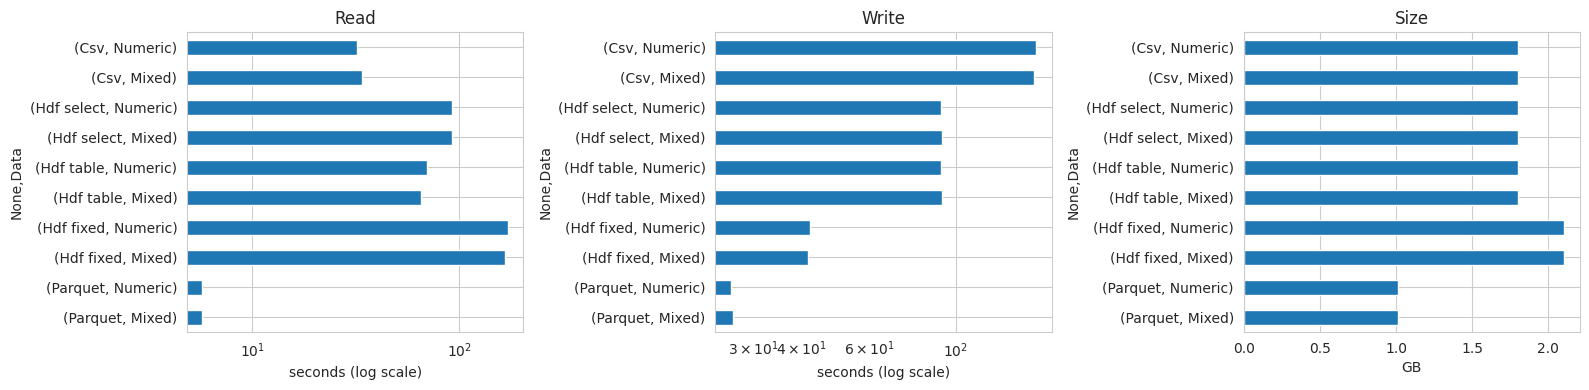

In [96]:
print(df.columns)

import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is already defined as your DataFrame

fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

# Loop through the operations you want to plot
for i, op in enumerate(['read', 'write', 'size']):
    flag = op in ['read', 'write']
    
    # Accessing the MultiIndex DataFrame
    df.loc[op].plot.barh(title=op.capitalize(), ax=axes[i], logx=flag)
    
    if flag:
        axes[i].set_xlabel('seconds (log scale)')
    else:
        axes[i].set_xlabel('GB')

fig.tight_layout()
fig.savefig('storage.png', dpi=300)
plt.show()
